# =============================
# BÀI TẬP 1: Mô hình cây quyết định cho hệ khuyến nghị
# =============================

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
import zipfile

pd.set_option("display.max_columns", None)

In [89]:
ml_100k_url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
ml_100k_zip = 'ml-100k.zip'
ml_100k_folder = 'ml-100k'

if not os.path.exists(ml_100k_folder):
    if not os.path.exists(ml_100k_zip):
        print('Downloading MovieLens 100K dataset...')
        urllib.request.urlretrieve(ml_100k_url, ml_100k_zip)
    print('Extracting MovieLens 100K dataset...')
    with zipfile.ZipFile(ml_100k_zip, 'r') as zip_ref:
        zip_ref.extractall('.')

# Đọc dữ liệu đánh giá
ratings_cols = ['userID', 'itemID', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Đọc thông tin người dùng
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

# Đọc thông tin phim
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date',
               'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation',
               'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
               'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
               'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [90]:
ratings_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [92]:
users[users["user_id"] == 196]

,user_id,age,gender,occupation,zip_code
195,196,49,M,writer,55105


In [96]:
movies[movies["movie_id"] == 242]

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
241,242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
len(users.occupation.unique())

21

In [104]:
# TODO: Tiền xử lý dữ liệu
# 1. Chuyển đổi đặc trưng phân loại (gender, occupation) thành one-hot encoding
users_processed = users.copy()
users_processed = pd.get_dummies(users_processed, columns=['gender', 'occupation'])
users_processed[users_processed["user_id"] == 196]

,user_id,age,zip_code,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,occupation_librarian,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
195,196,49,55105,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [ ]:
# 2. Chuẩn hóa đặc trưng số (age)
# scaler = StandardScaler()
# users_processed['age'] = scaler.fit_transform(users_processed[['age']])

In [105]:
# 3. Kết hợp đặc trưng người dùng và phim với đánh giá
# Đổi tên cột cho phù hợp khi merge
ratings_df_merged = ratings_df.merge(users_processed, left_on='userID', right_on='user_id', how='left', validate='m:1')
ratings_df_merged = ratings_df_merged.merge(movies, left_on='itemID', right_on='movie_id', how='left', validate='m:1')
ratings_df_merged.head()

,userID,itemID,rating,timestamp,user_id,age,zip_code,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,occupation_librarian,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,196,49,55105,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,186,39,00000,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,22,25,40206,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,377,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,244,28,80525,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,51,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,166,47,55113,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,346,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [110]:
# Bỏ các cột không cần thiết cho mô hình (giữ lại các đặc trưng số và one-hot, loại bỏ text, id, timestamp...)
feature_cols = [
    col for col in ratings_df_merged.columns
    if col not in ['userID', 'itemID', 'rating', 'timestamp', 'user_id', 'zip_code',
                   'movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
]
X = ratings_df_merged[feature_cols]

X.head()

,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,occupation_librarian,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,liked
0,49,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
2,25,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0
4,47,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [111]:
# TODO: Tạo biến mục tiêu (thích/không thích)
# ratings_df['liked'] = ratings_df['rating'] >= 4
ratings_df_merged['liked'] = ratings_df_merged['rating'] >= 4
ratings_df_merged['liked'] = ratings_df_merged['liked'].astype(int)
y = ratings_df_merged['liked']

In [112]:
y.head()

,liked
0,0
1,0
2,0
3,0
4,0


In [63]:
# TODO: Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [113]:
# TODO: Xây dựng và huấn luyện mô hình cây quyết định
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [121]:
# TODO: Đánh giá hiệu suất mô hình
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [115]:
X_test.head(3)

,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,occupation_librarian,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
88074,24,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
86913,28,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89152,26,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [116]:
y_test.head(3)

,liked
88074,0
86913,1
89152,1


In [120]:
y_pred[:3]

array([1, 1, 1])

In [122]:
y_pred_proba[:3]

array([[0.49804739, 0.50195261],
       [0.49804739, 0.50195261],
       [0.49804739, 0.50195261]])

In [124]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
# rec = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
# print(f"Precision: {prec:.4f}")
# print(f"Recall: {rec:.4f}")
# print(f"F1-score: {f1:.4f}")

Accuracy: 0.5699


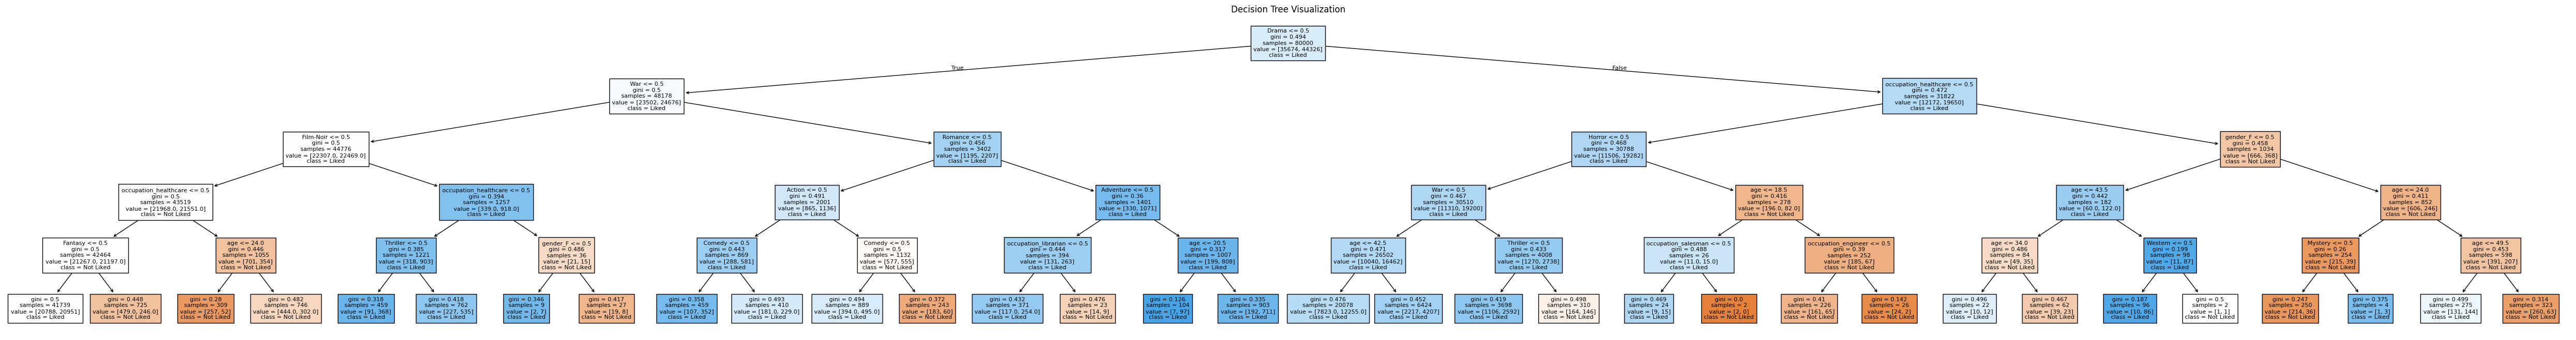

In [126]:
# TODO: Trực quan hóa cây quyết định và phân tích đặc trưng quan trọng
plt.figure(figsize=(64, 8))
plot_tree(clf, feature_names=X.columns, class_names=['Not Liked', 'Liked'], filled=True, max_depth=5, fontsize=8)
plt.title('Decision Tree Visualization')
plt.show()